<a href="https://www.kaggle.com/code/deepkayastha6890/bank-overdraft-pattern-finder?scriptVersionId=295706337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

# Addition paths
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-transaction-data/bank.xlsx


In [2]:
file_path = 'bank.xlsx'

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "apoorvwatsky/bank-transaction-data",
    file_path,
)

# Dataframe first five rows
print("\n\nFirst 5 records:")
display(df.head())


/tmp/ipykernel_17/3806805928.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(




First 5 records:


,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [3]:
def DataCleaning(df): 
    
    cleaningData = df.copy()

    #Finding the information 
    print("\n\nInformations:\n",cleaningData.info())

    # Finding the null values
    majorColumns = ['DEPOSIT AMT','WITHDRAWAL AMT','DATE','VALUE DATE']
    for i in majorColumns:
        print(f'\n\n{i} : ',cleaningData[i].isnull().sum())

    # Filling the null values
    nullValuesFiller = ['DEPOSIT AMT','WITHDRAWAL AMT','CHQ.NO.']
    for i in nullValuesFiller:
        cleaningData[i] = cleaningData[i].fillna(0)

    # Just changing the date name
    cleaningData['ActualDate'] = cleaningData['VALUE DATE']
    
    # Seperating the day , month , year 
    cleaningData['ActualDay'] = cleaningData['VALUE DATE'].dt.day 
    cleaningData['ActualMonth'] = cleaningData['VALUE DATE'].dt.month
    cleaningData['ActualYear'] = cleaningData['VALUE DATE'].dt.year

    # Sorting the data from starting date
    cleaningData = cleaningData.sort_values(by="VALUE DATE", ascending=False)

    # Droping unuseful data colums [Account No, , . ,CHQ.NO. ]
    cleaningData = cleaningData.drop(columns=['Account No','.','CHQ.NO.','VALUE DATE'])

    # Finding the columns 
    print('\n')
    print(cleaningData.columns)

    # finding the shape
    print("\nDataset Size",cleaningData.shape)

    # Finding the data discribtion 
    print('\nDiscribtion of the data : ')
    display(cleaningData.describe())
    
    return cleaningData
    
cleanData = DataCleaning(df)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Account No           116201 non-null  object        
 1   DATE                 116201 non-null  datetime64[ns]
 2   TRANSACTION DETAILS  113702 non-null  object        
 3   CHQ.NO.              905 non-null     float64       
 4   VALUE DATE           116201 non-null  datetime64[ns]
 5   WITHDRAWAL AMT       53549 non-null   float64       
 6   DEPOSIT AMT          62652 non-null   float64       
 7   BALANCE AMT          116201 non-null  float64       
 8   .                    116201 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 8.0+ MB


Informations:
 None


DEPOSIT AMT :  53549


WITHDRAWAL AMT :  62652


DATE :  0


VALUE DATE :  0


Index(['DATE', 'TRANSACTION DETAILS', 'WITHDRAWAL AMT', 'DEPOSIT AMT',
       

,DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDate,ActualDay,ActualMonth,ActualYear
count,116201,1.162010e+05,1.162010e+05,1.162010e+05,116201,116201.000000,116201.000000,116201.000000
mean,2017-05-20 00:08:40.477448448,2.068757e+06,2.052394e+06,-1.404852e+09,2017-05-20 00:04:43.288440064,15.615907,6.680313,2016.869993
min,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,-2.045201e+09,2015-01-01 00:00:00,1.000000,1.000000,2015.000000
25%,2016-05-30 00:00:00,0.000000e+00,0.000000e+00,-1.690383e+09,2016-05-30 00:00:00,8.000000,4.000000,2016.000000
50%,2017-06-05 00:00:00,0.000000e+00,5.000000e+03,-1.661395e+09,2017-06-05 00:00:00,15.000000,7.000000,2017.000000
75%,2018-05-26 00:00:00,2.682500e+04,5.000000e+05,-1.236888e+09,2018-05-26 00:00:00,23.000000,10.000000,2018.000000
max,2019-03-05 00:00:00,4.594475e+08,5.448000e+08,8.500000e+06,2019-03-05 00:00:00,31.000000,12.000000,2019.000000
std,NaN,7.696881e+06,6.652164e+06,5.348202e+08,NaN,8.602524,3.491998,1.131124


In [4]:
def DataDiscribtion(df):

    dataDiscribe = df.copy()
    
    # Year wise count
    total_year_counts = dataDiscribe['ActualYear'].value_counts()

    print("Total list of year : ")
    display(total_year_counts.head())
    print("\n")
    
    # function wise distributions
    display(dataDiscribe.describe())

    # Less Then Zero balance
    count =0
    for value in dataDiscribe['BALANCE AMT']:
        if(value < 0):
            count = count +1;
            
    # Counting the minus value
    print("\n\nMinus Value in balance : ",count)

DataDiscribtion(cleanData)


Total list of year : 


ActualYear
2018    35534
2016    30373
2017    29112
2015    15658
2019     5524
Name: count, dtype: int64

,DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDate,ActualDay,ActualMonth,ActualYear
count,116201,1.162010e+05,1.162010e+05,1.162010e+05,116201,116201.000000,116201.000000,116201.000000
mean,2017-05-20 00:08:40.477448448,2.068757e+06,2.052394e+06,-1.404852e+09,2017-05-20 00:04:43.288440064,15.615907,6.680313,2016.869993
min,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,-2.045201e+09,2015-01-01 00:00:00,1.000000,1.000000,2015.000000
25%,2016-05-30 00:00:00,0.000000e+00,0.000000e+00,-1.690383e+09,2016-05-30 00:00:00,8.000000,4.000000,2016.000000
50%,2017-06-05 00:00:00,0.000000e+00,5.000000e+03,-1.661395e+09,2017-06-05 00:00:00,15.000000,7.000000,2017.000000
75%,2018-05-26 00:00:00,2.682500e+04,5.000000e+05,-1.236888e+09,2018-05-26 00:00:00,23.000000,10.000000,2018.000000
max,2019-03-05 00:00:00,4.594475e+08,5.448000e+08,8.500000e+06,2019-03-05 00:00:00,31.000000,12.000000,2019.000000
std,NaN,7.696881e+06,6.652164e+06,5.348202e+08,NaN,8.602524,3.491998,1.131124




Minus Value in balance :  113276


In [5]:
# Count of compressed features
def groupByCounting(df, respectedMainFeature, copresstionFeatures):
    return (
        df
        .groupby(respectedMainFeature)[copresstionFeatures]
        .count()
        .sort_index()
    )
# Sum of the compress features
def groupBySum(df, respectedMainFeature, copresstionFeatures):
    return (
        df
        .groupby(respectedMainFeature)[copresstionFeatures]
        .sum()
        .sort_index()
    )


In [6]:
overDraft=0
# Preprocessed data
def DataPreProcess(df):
    
    processData = df.copy()

    # Generating new column Overdraft
    processData['OverdraftAmount'] = (-processData['BALANCE AMT']).clip(lower=0)
    # Global mjor compression column
    compressColumns = ['BALANCE AMT','DEPOSIT AMT','WITHDRAWAL AMT','OverdraftAmount']

    # Days wise sum and count of features
    dayAggData = groupBySum(processData,['ActualDate'],compressColumns)
    dayAggCountData = groupByCounting(processData,['ActualDate'],['DEPOSIT AMT','WITHDRAWAL AMT'])

    # Month wise sum and count of features
    monthAggData = groupBySum(processData,['ActualYear','ActualMonth'],compressColumns)
    monthAggCountData = groupByCounting(processData,['ActualYear','ActualMonth'],['DEPOSIT AMT','WITHDRAWAL AMT'])

    # Year wise sum and count of features
    yearAggData = groupBySum(processData,['ActualYear'],compressColumns)
    yearAggCountData = groupByCounting(processData,['ActualYear'],['DEPOSIT AMT','WITHDRAWAL AMT'])
    
    # Maping the months and days
    monthAggData.index = pd.to_datetime(
        monthAggData.index.map(lambda x: f"{x[0]}-{x[1]}-01")
    )

    # Normalizing the given data
    log_cols = ['DEPOSIT AMT', 'WITHDRAWAL AMT', 'OverdraftAmount']

    # Log normalization method
    for col in log_cols:
        processData[col] = np.log1p(processData[col])
        dayAggData[col] = np.log1p(dayAggData[col])
        monthAggData[col] = np.log1p(monthAggData[col])
        yearAggData[col] = np.log1p(yearAggData[col])

    # Replacing the zero values with smaller but countable values
    dayAggData['BurnRatio'] = dayAggData['WITHDRAWAL AMT'] / dayAggData['DEPOSIT AMT'].replace(0, 0.01)
    monthAggData['BurnRatio'] = monthAggData['WITHDRAWAL AMT'] / monthAggData['DEPOSIT AMT'].replace(0, 0.01)
    yearAggData['BurnRatio'] = yearAggData['WITHDRAWAL AMT'] / yearAggData['DEPOSIT AMT'].replace(0, 0.01)
    
    return processData, dayAggData, monthAggData, yearAggData , dayAggCountData , monthAggCountData ,yearAggCountData , overDraft

processData,dayAggData,monthAggData,yearAggData ,dayAggCountData ,monthAggCountData ,yearAggCountData,overDraft = DataPreProcess(cleanData)

display(processData.head())
display(dayAggData.head())
display(monthAggData.head())
display(yearAggData.head())


,DATE,TRANSACTION DETAILS,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDate,ActualDay,ActualMonth,ActualYear,OverdraftAmount
116200,2019-03-05,Sweep Trf To: 40900036427,8.517393,0.000000,-1.901417e+09,2019-03-05,5,3,2019,21.365865
27037,2019-03-05,MICRO ATM WDL FEE DT04031,0.000000,12.184854,-5.393314e+08,2019-03-05,5,3,2019,20.105841
86355,2019-03-05,FDRL/INTERNAL FUND TRANSFE,0.000000,12.611541,-1.686924e+09,2019-03-05,5,3,2019,21.246173
86356,2019-03-05,FDRL/INTERNAL FUND TRANSFE,12.611541,0.000000,-1.687224e+09,2019-03-05,5,3,2019,21.246351
86357,2019-03-05,FDRL/INTERNAL FUND TRANSFE,12.611541,0.000000,-1.687524e+09,2019-03-05,5,3,2019,21.246528


,BALANCE AMT,DEPOSIT AMT,WITHDRAWAL AMT,OverdraftAmount,BurnRatio
ActualDate,,,,,
2015-01-01,-3.710589e+09,14.511155,0.000000,22.034457,0.000000
2015-01-02,-1.481999e+10,14.717954,15.520269,23.419243,1.054513
2015-01-03,-6.353216e+09,14.896692,14.603968,22.572227,0.980350
2015-01-05,-1.172347e+10,15.178798,14.988303,23.184858,0.987450
2015-01-06,-9.530186e+09,15.110443,15.171360,22.977730,1.004031


,BALANCE AMT,DEPOSIT AMT,WITHDRAWAL AMT,OverdraftAmount,BurnRatio
2015-01-01,-3.101637e+11,18.571223,18.550123,26.460366,0.998864
2015-02-01,-4.168798e+11,18.658697,18.647248,26.756064,0.999386
2015-03-01,-3.772933e+11,18.502580,18.542858,26.656289,1.002177
2015-04-01,-4.063980e+11,18.575013,18.570813,26.730599,0.999774
2015-05-01,-5.997627e+11,18.898180,18.894510,27.119800,0.999806


,BALANCE AMT,DEPOSIT AMT,WITHDRAWAL AMT,OverdraftAmount,BurnRatio
ActualYear,,,,,
2015,-2.394343e+13,24.671244,24.696116,30.806715,1.001008
2016,-4.804100e+13,25.326214,25.329763,31.503094,1.000140
2017,-4.206498e+13,24.769775,24.763659,31.370260,0.999753
2018,-4.313675e+13,24.076642,24.096686,31.395432,1.000832
2019,-6.059047e+12,20.805031,20.815207,29.432606,1.000489


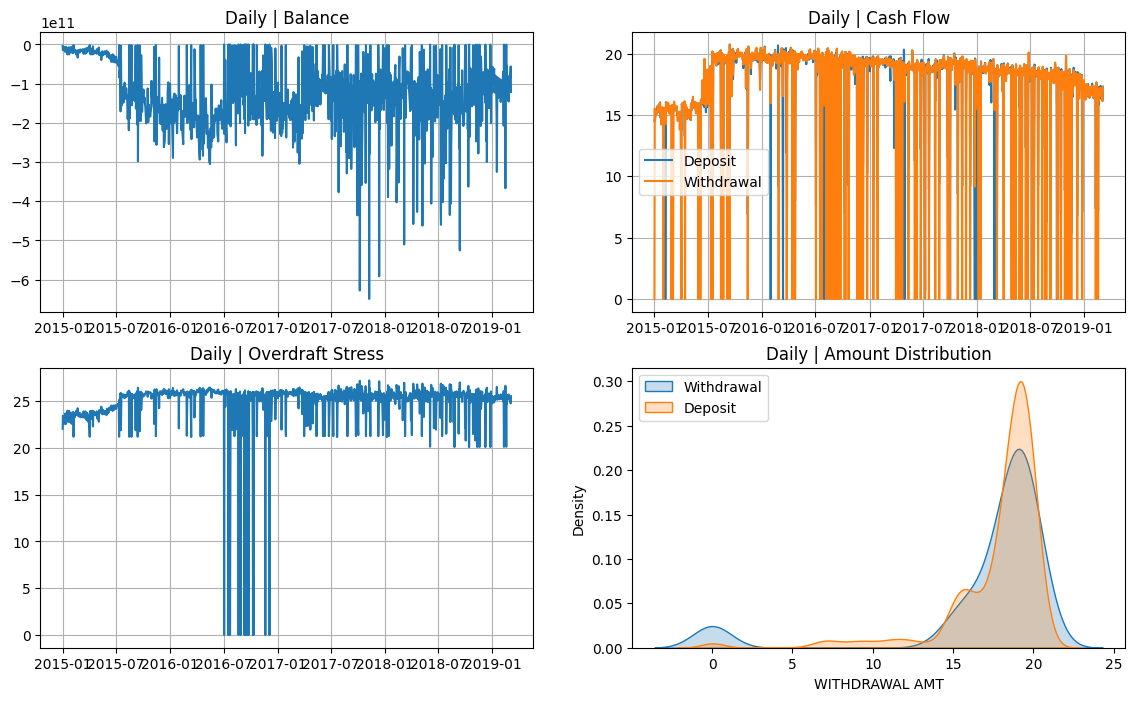

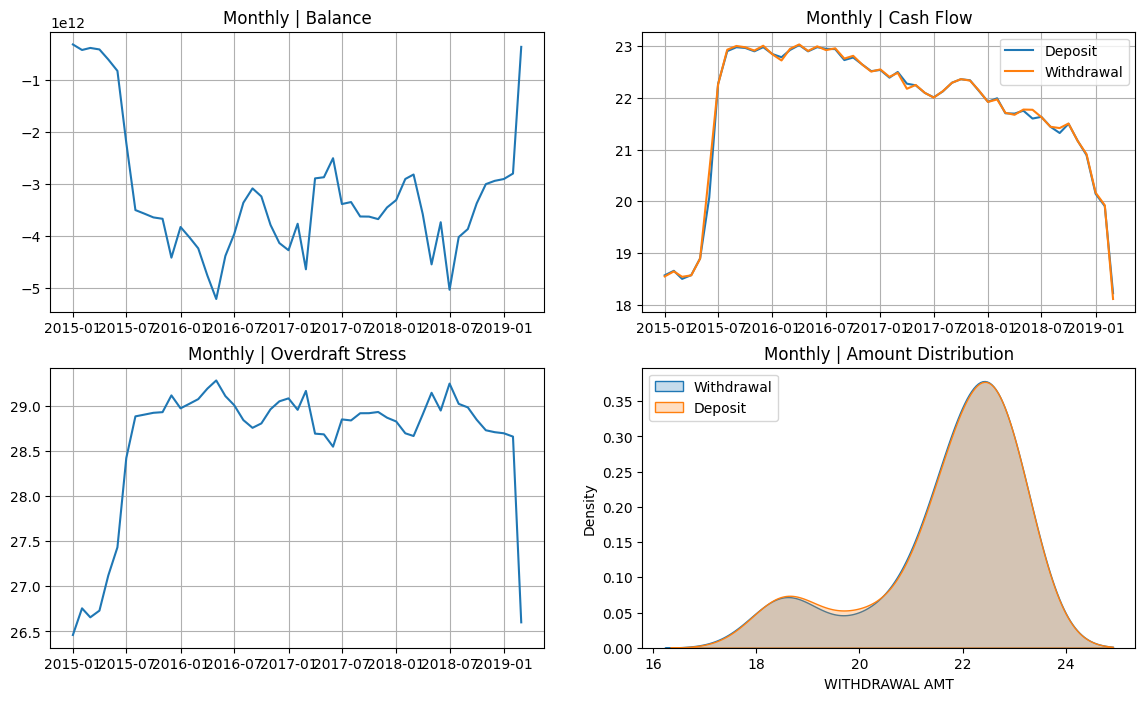

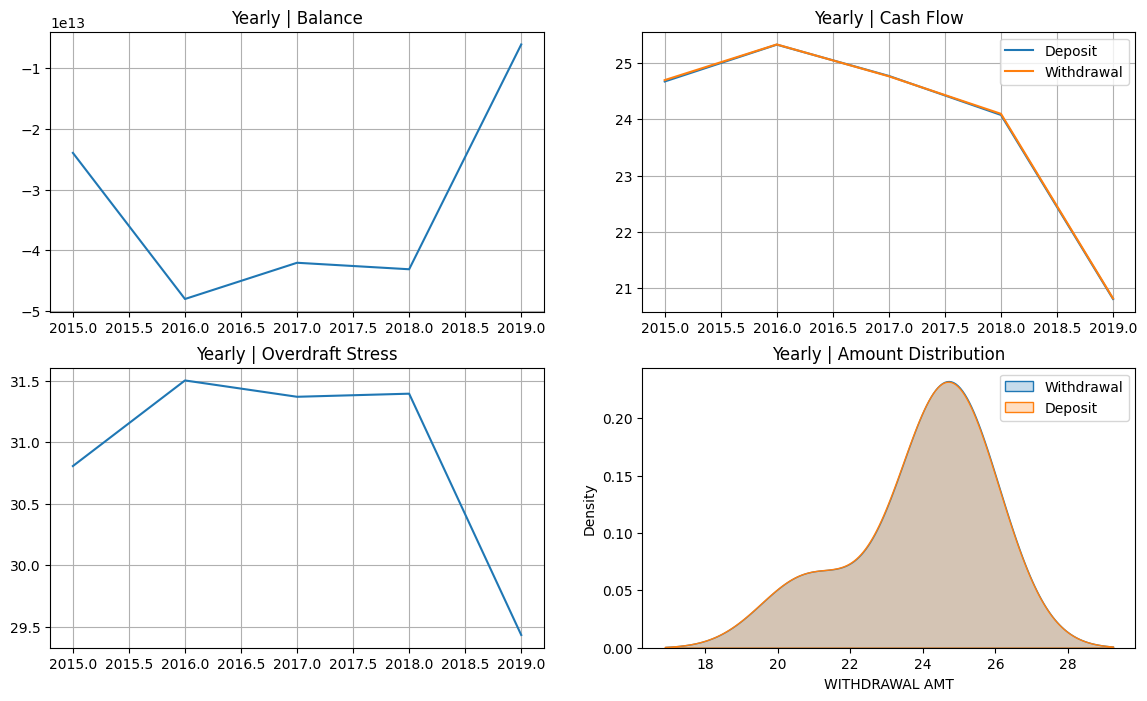

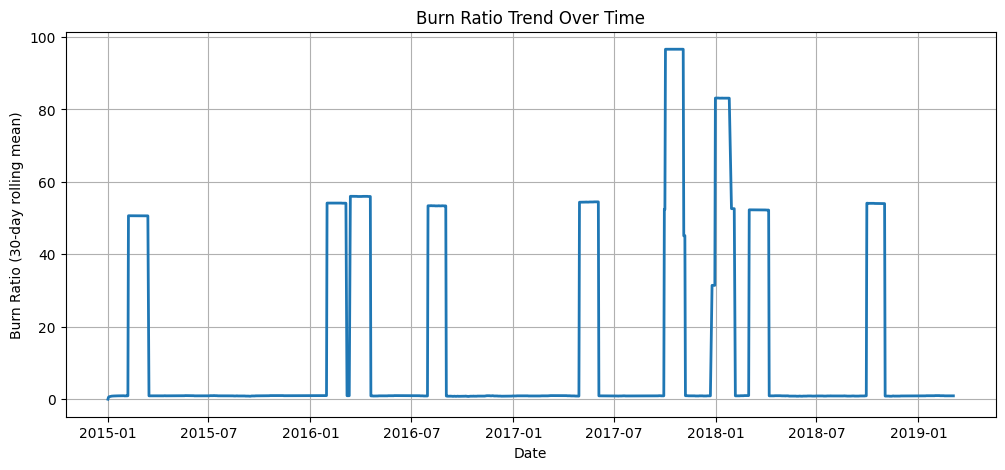

In [7]:
def visualization(df, title_prefix='Time Series Analysis'):
    # Sorting the dataset
    df = df.sort_index()

    plt.figure(figsize=(14, 8))

    # 1. Balance Trend
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df['BALANCE AMT'])
    plt.title(f'{title_prefix} | Balance')
    plt.grid(True)

    # 2. Deposit vs Withdrawal
    plt.subplot(2, 2, 2)
    plt.plot(df.index, df['DEPOSIT AMT'], label='Deposit')
    plt.plot(df.index, df['WITHDRAWAL AMT'], label='Withdrawal')
    plt.legend()
    plt.title(f'{title_prefix} | Cash Flow')
    plt.grid(True)

    # 3. Overdraft Stress
    plt.subplot(2, 2, 3)
    plt.plot(df.index, df['OverdraftAmount'])
    plt.title(f'{title_prefix} | Overdraft Stress')
    plt.grid(True)

    # 4. Distribution Insight
    plt.subplot(2, 2, 4)
    sns.kdeplot(df['WITHDRAWAL AMT'], label='Withdrawal', fill=True)
    sns.kdeplot(df['DEPOSIT AMT'], label='Deposit', fill=True)
    plt.legend()
    plt.title(f'{title_prefix} | Amount Distribution')
    
    plt.show()

# Day wise visulization
visualization(dayAggData, 'Daily')

# Month wise visulization
visualization(monthAggData, 'Monthly')

# Year wise visulization
visualization(yearAggData, 'Yearly')

# Rolling trend of 30 days
trend = dayAggData['BurnRatio'].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(dayAggData.index, trend, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Burn Ratio (30-day rolling mean)')
plt.title('Burn Ratio Trend Over Time')
plt.grid(True)
plt.show()
 

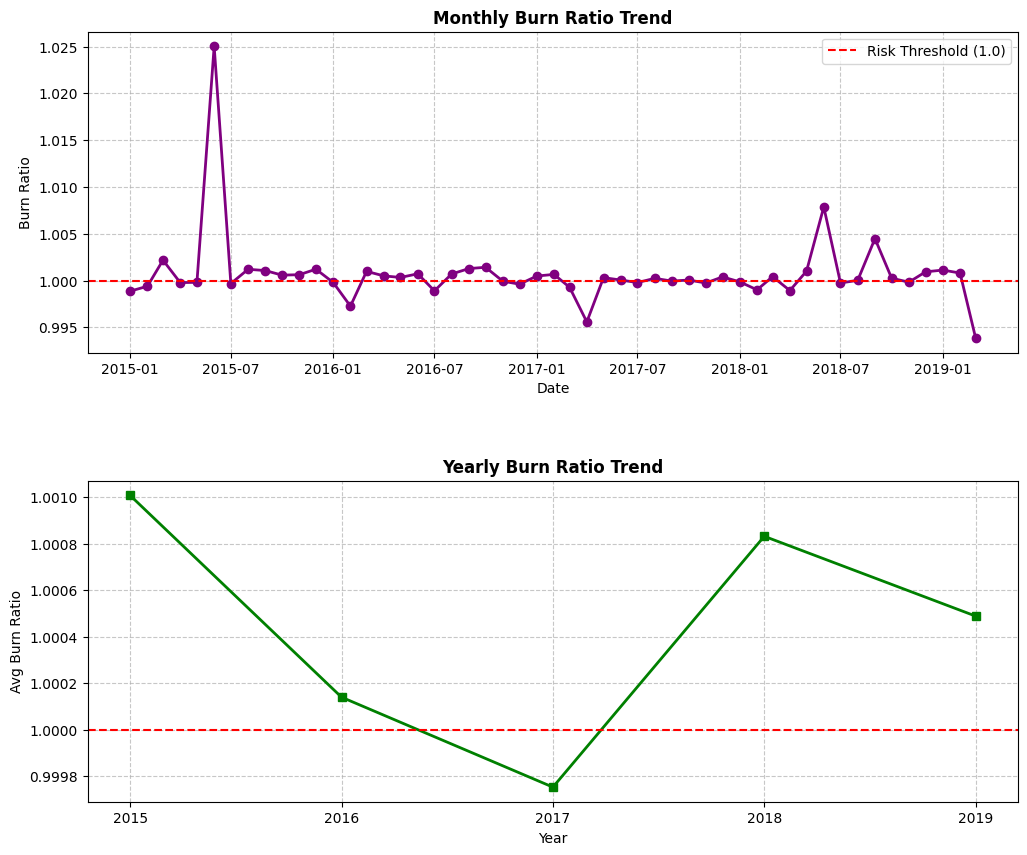

In [8]:
# Resetting the column index
if 'ActualDate' not in monthAggData.columns:
    monthAggData = monthAggData.reset_index()
    if 'index' in monthAggData.columns:
        monthAggData = monthAggData.rename(columns={'index': 'ActualDate'})

# Resetting the year wise index
if 'ActualYear' not in yearAggData.columns:
    yearAggData = yearAggData.reset_index()

# Plotting two graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

# Burn ratio monthwise
ax1.plot(monthAggData['ActualDate'], monthAggData['BurnRatio'], 
         marker='o', color='purple', linewidth=2)
ax1.set_title('Monthly Burn Ratio Trend', fontsize=12, fontweight='bold')
ax1.set_ylabel('Burn Ratio')
ax1.set_xlabel('Date')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.axhline(y=1.0, color='red', linestyle='--', label='Risk Threshold (1.0)')
ax1.legend()

# X Axis column set as a timeseries
x_col = 'ActualYear' if 'ActualYear' in yearAggData.columns else yearAggData.columns[0]

# Taking values of columns as string
x_vals = yearAggData[x_col].astype(str)

ax2.plot(x_vals, yearAggData['BurnRatio'], 
         marker='s', color='green', linewidth=2)
ax2.set_title('Yearly Burn Ratio Trend', fontsize=12, fontweight='bold')
ax2.set_ylabel('Avg Burn Ratio')
ax2.set_xlabel('Year')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axhline(y=1.0, color='red', linestyle='--', label='Risk Threshold (1.0)')

ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.show()

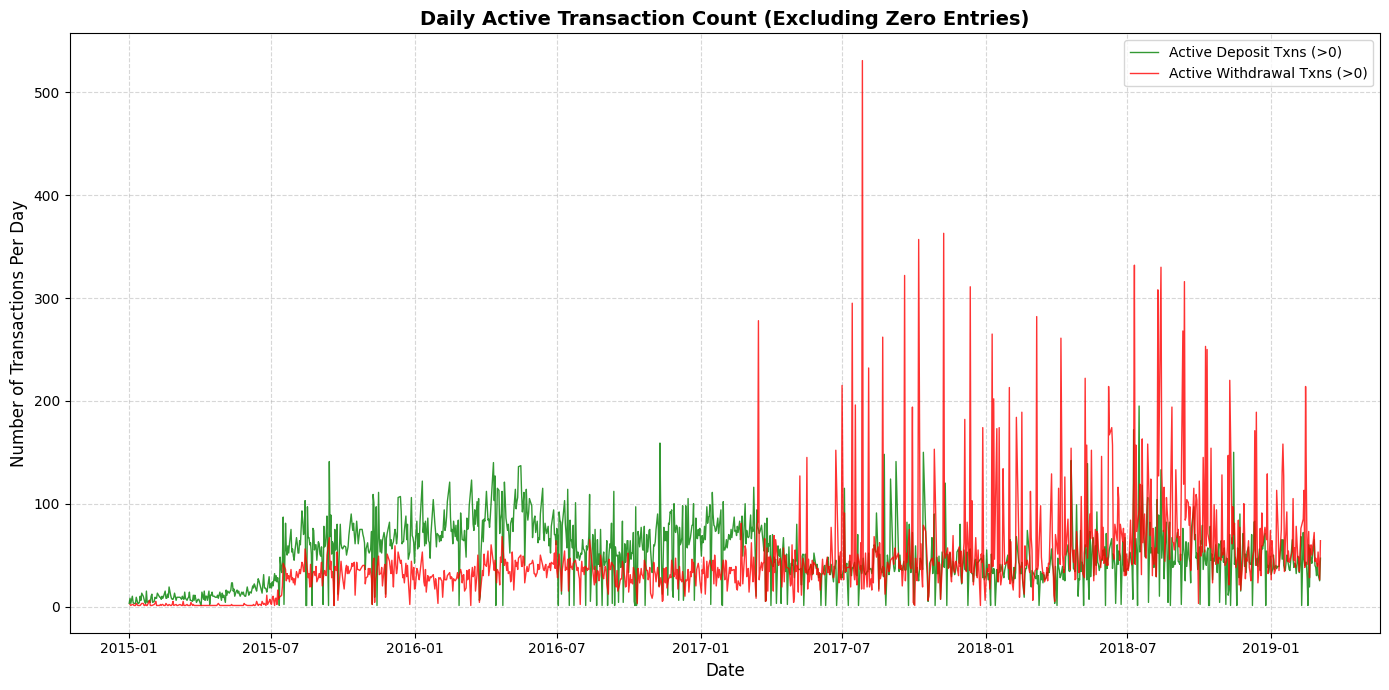

In [9]:
# Compressing the day wise multiple transaction
daily_deposit_counts = groupByCounting(processData[processData['DEPOSIT AMT'] > 0],
                                       ['ActualDate'],['DEPOSIT AMT'])
daily_withdrawal_counts = groupByCounting(processData[processData['WITHDRAWAL AMT'] > 0],
                                       ['ActualDate'],['WITHDRAWAL AMT'])

plt.figure(figsize=(14, 7))
# Plot Deposit Counts
plt.plot(daily_deposit_counts.index, daily_deposit_counts, 
         label='Active Deposit Txns (>0)', color='green', linewidth=1, alpha=0.8)
# Plot Withdrawal Counts
plt.plot(daily_withdrawal_counts.index, daily_withdrawal_counts, 
         label='Active Withdrawal Txns (>0)', color='red', linewidth=1, alpha=0.8)

# 3. Formatting
plt.title('Daily Active Transaction Count (Excluding Zero Entries)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions Per Day', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

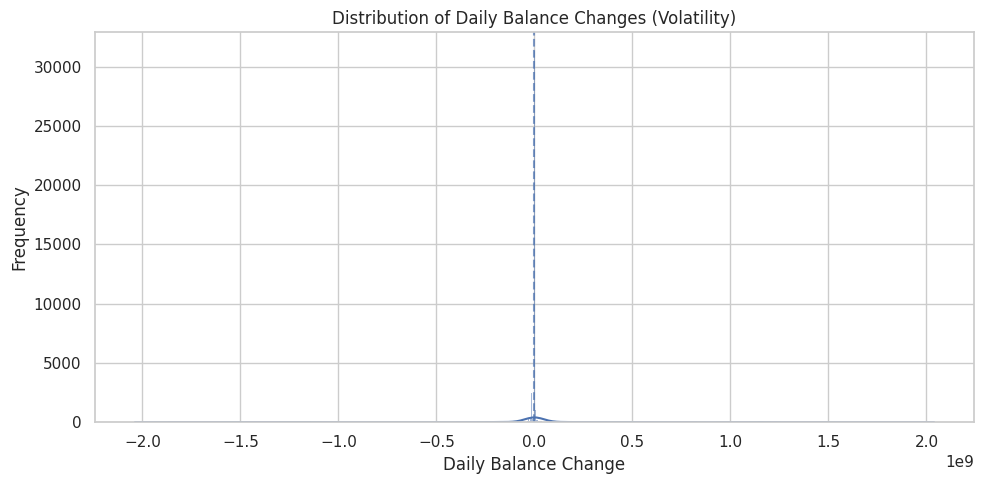

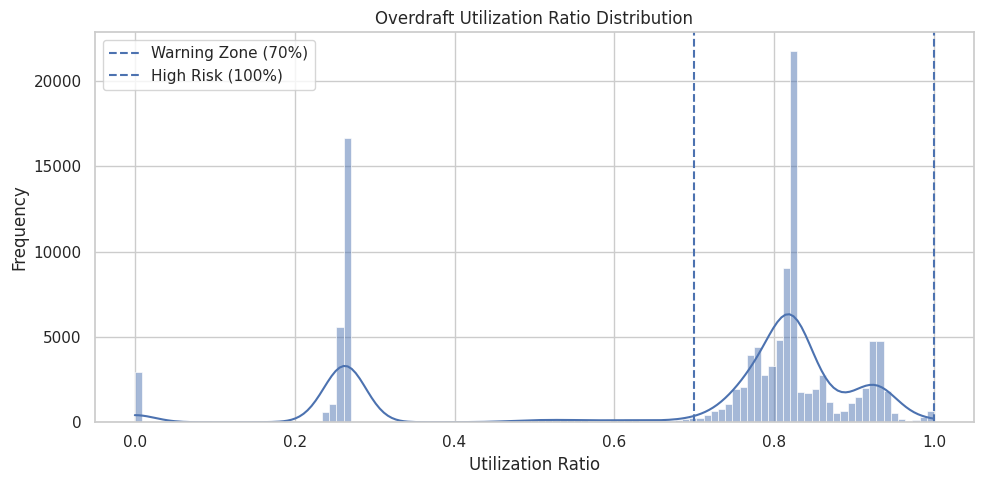

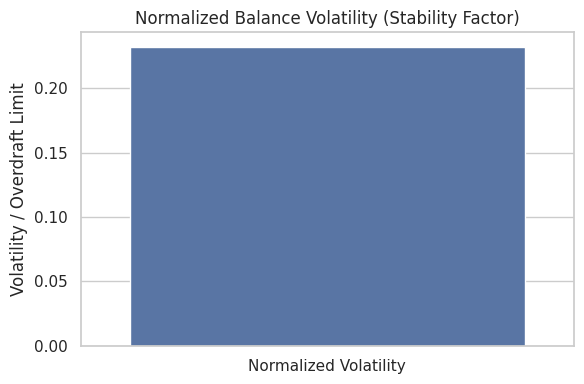

In [10]:
sns.set(style="whitegrid")

overDraftLimit = 2_045_201_000 

# RiskIndex
def riskIndexer(df):
    elementsData = df.sort_values('DATE').copy()

    # Overdraft amount
    elementsData['OverdraftAmount'] = (-elementsData['BALANCE AMT']).clip(lower=0)

    # Daily balance change (CORRECT)
    elementsData['BalanceChange'] = elementsData['BALANCE AMT'].diff()
    # elementsData = elementsData[elementsData['BalanceChange'].abs() < 2]


    # Overdraft utilization
    draftUtil = elementsData['OverdraftAmount'] / overDraftLimit

    # Burn ratio (already computed)
    burnRatio = yearAggData['BurnRatio']

    # Balance volatility
    balanceVolatility = elementsData['BalanceChange'].std()

    # Normalized volatility
    normVolatility = balanceVolatility / overDraftLimit

    return elementsData, draftUtil, burnRatio, normVolatility


df, draftUtil, burnRatio, normVolatility = riskIndexer(cleanData)

# Balance changes 
plt.figure(figsize=(10, 5))
sns.histplot(df['BalanceChange'].dropna(), kde=True)
plt.axvline(0, linestyle='--', alpha=0.7)
plt.title("Distribution of Daily Balance Changes (Volatility)")
plt.xlabel("Daily Balance Change")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Overdraft utilization ratio
plt.figure(figsize=(10, 5))
sns.histplot(draftUtil.dropna(), kde=True)
plt.axvline(0.7, linestyle='--', label='Warning Zone (70%)')
plt.axvline(1.0, linestyle='--', label='High Risk (100%)')
plt.title("Overdraft Utilization Ratio Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Volatality
plt.figure(figsize=(6, 4))
sns.barplot(x=['Normalized Volatility'], y=[normVolatility])
plt.ylabel("Volatility / Overdraft Limit")
plt.title("Normalized Balance Volatility (Stability Factor)")
plt.tight_layout()
plt.show()